In [1]:
import numpy  as np 
import pandas as pd
from   glob   import glob
import itertools
import importlib
import time
import os
from concurrent.futures import ProcessPoolExecutor
from pylab import plt

np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.3g" % x))
np.set_printoptions(precision=8)

import talib
from data_provider import  read_prices, read_data
from tp_config import *
%matplotlib inline


In [3]:
#Торговля c изменением позиции
def simulation_02(prices, init_data, no_commission = False, no_correction = False):
    market          = init_data['market']
    taker           = init_data['taker'] / 100
    maker           = init_data['maker'] / 100
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
    contract        = init_data['contract']
     
    if no_commission : 
        maker = 0 
        taker = 0
    
    if no_correction:
        buy_correction = 1
        sell_correction = 1
        
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0    
    market_position = 0
    
  
    ticks = prices['C'].values
    moves = np.diff(ticks)
    times = prices['T'].values
    start = len(ticks) - len(moves) 
    ticks = ticks[start:]
    times = times[start:]
    trade_statistics = []
    trades = 0

  #  streak_buy_len = 3
  #  streak_sell_len = 4
    
#   streak_buy_len = 5,6
#   streak_sell_len = 2
#   alert -100
#   stay_away_time = 60
    
    streak_buy_len = 6
    streak_sell_len = 2
    price_treshold = 1 + taker * 5
    alert = -90
    stay_away_time = 30
#    streak_stop_len = 8
    
    
    streak_buy = 0
    streak_sell = 0
    streak_all = 0
    signal_buy = 0
    signal_sell = 0
    num_shares = 0
    open_position = 0
    market_position = 0
    stay_away = 0

    
    for i in range(len(ticks)) :           
        if stay_away > 0 :
            stay_away =stay_away - 1
            continue

        ts = ts_to_datetime(times[i]/1000)
        trade_profit = 0
            
        market_move = np.sign(moves[i])
        streak_all = streak_all + market_move 
        if market_move == -1 :
            streak_buy += 1
            streak_sell = 0
        elif market_move == 1 :
            streak_sell +=1
            streak_buy = 0
            
        if market_position  == 0 and streak_buy == streak_buy_len :    
            signal_buy = 1
            market_position = 1
            streak_all = 0
        elif market_position == 1 and (streak_sell == streak_sell_len):    
            signal_sell = 1
            market_position = 0
            streak_all = 0
#        elif market_position == 1 and (ticks[i] > price_buy * price_treshold):  
#            signal_sell = 1
#            market_position = 0
#            streak_all = 0
 
             
        if moves[i] < alert : 
            stay_away = stay_away_time
            signal_sell = 1
            market_positon = 0
        
        if signal_buy:
            signal_buy = 0    
            num_shares = num_shares + contract
            price_buy = ticks[i] * buy_correction
            open_position = open_position + contract * price_buy *(1 + taker)         
        elif signal_sell:
            signal_sell = 0
            price = ticks[i] * sell_correction
            close_position = num_shares * price * (1 - taker)
            trade_profit = close_position - open_position
            cum_profit  += trade_profit
            num_shares   = 0
            open_position = 0
            trades = trades + 1

            streak = 0        
        trade_statistics.append([ts, moves[i],  ticks[i], streak_buy, streak_sell, market_position, num_shares, trade_profit, cum_profit, trades])            
            

    df = pd.DataFrame(trade_statistics)
    df.columns = ['time', 'move', 'price', 'buy', 'sell', 'MP', 'num_shares', 'profit', 'cum_profit', 'trades']
    df['high_val'] = df['cum_profit'].cummax()
    df['drawdown'] = df['cum_profit'] - df['high_val']
    df = df.astype({'buy':np.int32, 'MP':np.int32})
    return df
    #return 0

In [4]:
#vectorized simulation
from TA_robots import ma_2_crossover, ma_rsi, rsi
robot = ma_2_crossover()
#robot = rsi()
params = robot.ps_ranges

ticket = 'BTC-USDT'
tf = '1m'
#tf = '5m'
from_date = '2020-01-01'

prices = read_data(ticket, tf, from_date)
signals = robot.signals(prices, 12 , 25, 1)
#signals = robot.signals(prices, 4 , 34, 78)

init_data = {'taker': 0.075,
             'maker': 0.075, #percent
             'start_capital'     : 1,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'contract'          : 0.1,  
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

from datetime import datetime

def ts_to_datetime(ts):
#datetime.utcfromtimestamp(ts)
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

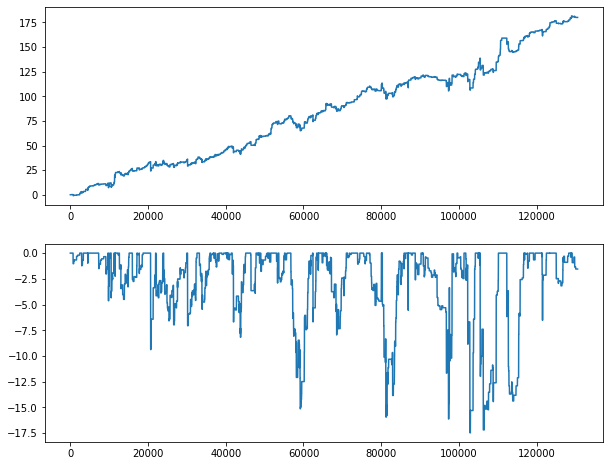

In [5]:
res = simulation_02(prices, init_data, no_commission = True, no_correction = False)

#res = res.iloc[102500:]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10,8))

res['cum_profit'].plot(ax=axes[0])
res['drawdown'].plot(ax=axes[1])
plt.show()

In [233]:
xx=res[350000:]
#xx = res[(res['profit'] != 0)]
#xx = res[(res['MP'] == 1) | (res['sell'] == 3)]
xx.head(50)

,time,move,price,buy,sell,MP,num_shares,profit,cum_profit,trades,high_val,drawdown
350000,2019-09-04 01:23:00,-2.46,10691.51,1,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350001,2019-09-04 01:24:00,-3.18,10688.33,2,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350002,2019-09-04 01:25:00,6.67,10695.00,0,1,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350003,2019-09-04 01:26:00,-0.87,10694.13,1,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350004,2019-09-04 01:27:00,0.28,10694.41,0,1,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350005,2019-09-04 01:28:00,-3.49,10690.92,1,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350006,2019-09-04 01:29:00,-7.96,10682.96,2,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350007,2019-09-04 01:30:00,-2.37,10680.59,3,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350008,2019-09-04 01:31:00,-0.60,10679.99,4,0,0,0.0,0.00000000,487.154153662,4768,518.784291281,-31.630137619
350009,2019-09-04 01:32:00,-3.16,10676.83,5,0,1,0.1,0.00000000,487.154153662,4768,518.784291281,-31.630137619


In [61]:
import matplotlib.pyplot as plt
Roll_Max = res['cum_profit'].cummax()
Daily_Drawdown = res['cum_profit']/Roll_Max - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()
Max_Daily_Drawdown


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
117344   -inf
117345   -inf
117346   -inf
117347   -inf
117348   -inf
Name: cum_profit, Length: 117349, dtype: float64

In [3]:
#Торговля на всю котлету
def simulation(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
            
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0

In [4]:
def simulation_short(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        #long entry
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
        #long exit
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        #short entry
        elif market_position == 0 and signals[i] == -1:
            price = ticks[i] * sell_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = num_shares * price
            market_position = 2
        #short exit
        elif market_position == 2 and signals[i] == 1:    
            price = ticks[i] * buy_correction
            cur_capital  = (num_shares * price)*(1-commission)
            num_shares = 0
            trade_profit = trade_profit - cur_capital
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0

In [ ]:
df[df['MP'] != df['']]

In [24]:
df[df['signal'] != 0]

,price,signal,MP,capital,num_shares,profit,cum_profit
134,4158.56,1,1,0.000000000,0.024046785,-100.000000000,0.000000000
1175,4580.00,-1,0,110.134277250,0.000000000,10.134277250,10.134277250
1526,4541.11,1,1,0.000000000,0.024252722,-110.134277250,10.134277250
3743,3937.75,-1,0,95.501155057,0.000000000,-14.633122193,-4.498844943
4475,4280.00,1,1,0.000000000,0.022313354,-95.501155057,-4.498844943
5103,4780.00,-1,0,106.657832050,0.000000000,11.156676993,6.657832050
5217,4740.00,1,1,0.000000000,0.022501652,-106.657832050,6.657832050
5348,5097.00,-1,0,114.690921932,0.000000000,8.033089882,14.690921932
5636,5570.01,1,1,0.000000000,0.020590793,-114.690921932,14.690921932
6144,5984.70,-1,0,123.229717807,0.000000000,8.538795876,23.229717807
